In [1]:
import nbimporter
import numpy as np
from preprocessing import parse_annotation, BatchGenerator
from Evaluate import evaluate
import matplotlib.pyplot as plt

from keras.models import load_model, Model
from keras.applications.mobilenet import MobileNet
from keras.layers import Reshape, Conv2D, Input, Lambda
from keras_applications.mobilenet import _depthwise_conv_block

%matplotlib inline

Using TensorFlow backend.


Importing Jupyter notebook from Evaluate.ipynb


In [2]:
def read_category():
    category = []
    with open('/Volumes/JS/UECFOOD100_JS/category.txt', 'r') as file:
        for i, line in enumerate(file):
            if i > 0:
                line = line.rstrip('\n')
                line = line.split('\t')
                category.append(line[1])
    return category

In [3]:
''' Initiailize parameters '''
LABELS = read_category()

IMAGE_H, IMAGE_W = 224, 224  # must equal to GRID_H * 32  416, 416
GRID_H, GRID_W = 7, 7 # 13, 13
N_BOX = 5
CLASS = len(LABELS)
CLASS_WEIGHTS = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD = 0.3
NMS_THRESHOLD = 0.3

# Read knn generated anchor_5.txt
ANCHORS = []
with open('/Volumes/JS/UECFOOD100_JS/generated_anchors_mobilenet/anchors_5.txt', 'r') as anchor_file:
    for i, line in enumerate(anchor_file):
        line = line.rstrip('\n')
        ANCHORS.append(list(map(float, line.split(', '))))
ANCHORS = list(list(np.array(ANCHORS).reshape(1, -1))[0])

NO_OBJECT_SCALE = 1.0
OBJECT_SCALE = 5.0
COORD_SCALE = 1.0
CLASS_SCALE = 1.0

BATCH_SIZE = 16
WARM_UP_BATCHES = 100
TRUE_BOX_BUFFER = 15

generator_config = {
    'IMAGE_H': IMAGE_H,
    'IMAGE_W': IMAGE_W,
    'GRID_H': GRID_H,
    'GRID_W': GRID_W,
    'BOX': N_BOX,
    'LABELS': LABELS,
    'CLASS': len(LABELS),
    'ANCHORS': ANCHORS,
    'BATCH_SIZE': BATCH_SIZE,
    'TRUE_BOX_BUFFER': TRUE_BOX_BUFFER,
}

all_imgs = []
for i in range(0, len(LABELS)):
    image_path = '/Volumes/JS/UECFOOD100_JS/' + str(i+1) + '/'
    annot_path = '/Volumes/JS/UECFOOD100_JS/' + str(i+1) + '/' + '/annotations_new/'

    folder_imgs, seen_labels = parse_annotation(annot_path, image_path)
    all_imgs.extend(folder_imgs)
print(np.array(all_imgs).shape)

# add extensions to image name
for img in all_imgs:
    img['filename'] = img['filename']

print('=> Generate BatchGenerator.')
batches = BatchGenerator(all_imgs, generator_config)

(14361,)
=> Generate BatchGenerator.


In [4]:
def normalize(image):
    return image / 255.

train_valid_split = int(0.8 * len(all_imgs))

train_batch = BatchGenerator(all_imgs[:train_valid_split], generator_config, norm=normalize, jitter=False)
valid_batch = BatchGenerator(all_imgs[train_valid_split:], generator_config, norm=normalize, jitter=False)

input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER, 4))

In [5]:
model = load_model('./record/mnv2_224_1007_normal/gap_foodnotfood_mn1_224.h5')

In [6]:
def get_normal_mn1():
    print('=> Building MobileNetV1 model...')
    mobilenet = MobileNet(input_shape=(224, 224, 3), include_top=False)
    x = mobilenet(input_image)
    x = Conv2D(N_BOX * (4 + 1 + CLASS), (1, 1), strides=(1, 1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W, N_BOX, 4 + 1 + CLASS))(x)
    output = Lambda(lambda args: args[0])([output, true_boxes])

    model = Model([input_image, true_boxes], output)
    print(model.summary())
    return model

In [7]:
def get_tla_mn1():
    alpha, depth_multiplier = 1, 1
    print('=> Building new model with pretrained MobilenetV1...')

    pretrained_gap_model = load_model('./record/mnv2_224_1007_normal/gap_foodnotfood_mn1_224.h5')
    
    model = Model(inputs=pretrained_gap_model.input, outputs=pretrained_gap_model.layers[-6].input)
    
    x = model(input_image)
    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier,
                              strides=(2, 2), block_id=12)
    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, block_id=13)

    x = Conv2D(N_BOX * (4 + 1 + CLASS), (1, 1), strides=(1, 1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W, N_BOX, 4 + 1 + CLASS))(x)
    output = Lambda(lambda args: args[0])([output, true_boxes])

    model = Model([input_image, true_boxes], output)
    print(model.summary())
    print('Finish new model.')
    return model

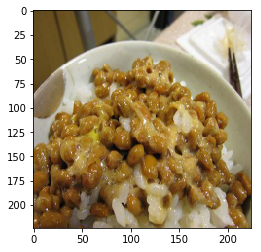

In [8]:
img = train_batch[0][0][0][2]
plt.imshow(img.astype('float'))  # beacuse of normalization

In [9]:
model = get_normal_mn1()

=> Building MobileNetV1 model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
mobilenet_1.00_224 (Model)      (None, 7, 7, 1024)   3228864     input_1[0][0]                    
__________________________________________________________________________________________________
conv_23 (Conv2D)                (None, 7, 7, 525)    538125      mobilenet_1.00_224[1][0]         
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 7, 7, 5, 105) 0           conv_23[0][0]                    
____________________________________________________________________________

In [10]:
model.load_weights('./record/mnv2_224_1007_normal/mnv2224_normal_1007_gcp.h5')

In [11]:
average_precisions = evaluate(model, valid_batch, net_h=224, net_w=224)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[[[0.5, 0.5, 0.5],
         [0.5, 0.5, 0.5],
         [0.5, 0.5, 0.5],
         ...,
         [0.5, 0.5, 0.5],
         [0.5, 0.5, 0.5],
         [0.5, 0.5, 0.5]],

        [[0.5, 0.5, 0.5],
 ...